# Classification of Malicious URL using Deep Learning via Keras


In [1]:
!pip install scikeras

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier, KerasRegressor

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# mount the colab
from google.colab import drive
drive.mount('/content/drive')

# For saving and retrieving the trained model
WORKSPACE_PATH = "/content/drive/MyDrive/Colab Notebooks/models/"

Mounted at /content/drive


# Load the dataset



In [4]:
# Read the dataset
url = 'https://raw.githubusercontent.com/quickheaven/scs-3546-deep-learning/master/datasets/'

X_train = pd.read_csv(url + 'X_train.csv', index_col=0)
X_test =pd.read_csv(url + 'X_test.csv', index_col=0)

y_train =pd.read_csv(url + 'y_train.csv', index_col=0)
y_test = pd.read_csv(url + 'y_test.csv', index_col=0)

In [5]:
y_train_dummy = to_categorical(y_train)
y_test_dummy = to_categorical(y_test)


# Training and Tuning Model

The training and tuning of model is divided into three main experiments. Tuning of Deep Network, Tuning the Back Propagation and last is the Overfitting Management.

The first step before proceeding to other experiments is Tuning the Neural Network. These includes determining first the epoch and batch size to use, the number of hidden layers to add, the number of nodes in each layer, choosing the activation function and the weight initializer.

The second part is Tuning the Back Propagation. It involves whether to use Batch normalization or not, finding the right Optimizers and its Learning Rates.

Lastly is the Overfitting Management, I used Regularation and Dropout as part of the experiment.
\
\

In [6]:

def get_base_model_config():
  """
  This function returns the based model configuration for the experiments.

  Parameters
  ----------
  None

  Returns
  ----------
  dict - The dictionary containing the based model configuration.
  """

  early_stopping_callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
  callbacks = [early_stopping_callback]

  model_config = {
      "model_name": None,
      "input_dim": 51,
      "epochs": 200,
      "validation_split": 0.20,
      "callbacks": callbacks,
      "batch_size": 32,
      "hidden_activation": "relu",
      "loss": "categorical_crossentropy",
      "weights_initializer": "random_normal",
      "output_nodes": 5, # TODO
      "output_activation": "softmax",
      "metrics": ['accuracy'],
      "normalization": None,
      "optimizer": "adam",
      "learning_rate": 0.001,
      "custom_layers": list(),
      "is_save_model": False,
      "workspace_path": WORKSPACE_PATH
  }
  return model_config


In [7]:
def get_optimizer(optimizer_name, learning_rate):
  """
  (str. float) -> keras.optimizers

  This method returns the optimizer that will be use in the experiment.

  Parameters
  ----------
  optimizer_name - The name of the optimizer to use in the experiment. values are adagrad, rmsprop, adam and None.
  learning_rate - The rate of learning to use in the optimizer.

  Returns
  ----------
  keras.optimizer - The keras optimizer object.
  """
  optimizer=None
  if optimizer_name == 'adagrad':
      optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
  elif 'rmsprop':
      optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif'adam' :
      optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  else :
      optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

  return optimizer

In [8]:
def create_and_run_model(model_config, X, y):

  # Build the new model
  model = Sequential(layers=model_config['custom_layers'], name=model_config['model_name'])
  model.summary()

  optimizer = get_optimizer(model_config["optimizer"], model_config["learning_rate"])

  # Compile the model
  model.compile(optimizer=optimizer,
                loss=model_config['loss'],
                metrics=model_config['metrics'])

  # Fit the model
  history = model.fit(X, y,
                      batch_size=model_config['batch_size'],
                      callbacks=model_config['callbacks'],
                      epochs=model_config['epochs'],
                      validation_split=model_config['validation_split'])

  if True == model_config['is_save_model']:
    model_file = str(model_config['workspace_path']) + str(model_config['model_name']) + '.h5'
    model.save(model_file)

  return history

In [9]:
def plot_accuracy_measures(accuracy_measures, title):

    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))
    for experiment in accuracy_measures.keys():
        plt.plot(accuracy_measures[experiment],
                 label=experiment,
                    linewidth=3)

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [10]:
def plot_learning_curves(history, title):
  # plot curves for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Learning Curves ' + title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.plot(figsize=(8, 5))
  plt.grid(True)
  plt.show()

In [11]:
model_config = get_base_model_config()

## Tuning Deep Neural Network

### Epoch and Batch size tuning
Figure out the right number of batches and epochs first, and then use that for further experimentation.

**Batch Size:** Experiment for the right size, batch size of 32 found most optimal for most use cases.

**Epoch:** Choose the earliest value when accuracy stabilizers.


Model: "Epoch_and_batch_size_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1664      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1829 (7.14 KB)
Trainable params: 1829 (7.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 5s 6ms/step - loss: 1.1980 - accuracy: 0.5873 - val_loss: 0.9827 - val_accuracy: 0.6502
Epoch 2/200
636/636 [==============================] - 2s 3ms/step - loss: 0.9125 - accuracy: 0.6844 - val_loss: 0.8508 - val_accuracy: 0.6965
Epoch 3/200
636/636 [==============================] - 2s 3ms/step - loss: 0.8243 - accuracy: 0.7057 - val_loss: 0.7888 -

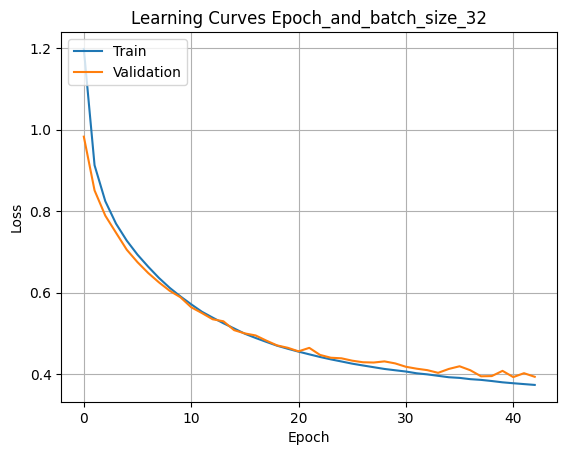

Model: "Epoch_and_batch_size_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                1664      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1829 (7.14 KB)
Trainable params: 1829 (7.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
318/318 [==============================] - 1s 3ms/step - loss: 1.3507 - accuracy: 0.5164 - val_loss: 1.1284 - val_accuracy: 0.6287
Epoch 2/200
318/318 [==============================] - 1s 2ms/step - loss: 1.0334 - accuracy: 0.6463 - val_loss: 0.9496 - val_accuracy: 0.6722
Epoch 3/200
318/318 [==============================] - 1s 2ms/step - loss: 0.9141 - accuracy: 0.6814 - val_loss: 0.8711 -

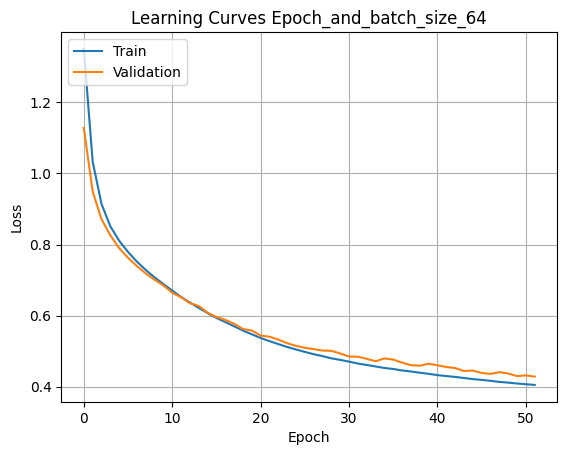

Model: "Epoch_and_batch_size_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                1664      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1829 (7.14 KB)
Trainable params: 1829 (7.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
159/159 [==============================] - 2s 6ms/step - loss: 1.4387 - accuracy: 0.4597 - val_loss: 1.2679 - val_accuracy: 0.5639
Epoch 2/200
159/159 [==============================] - 1s 4ms/step - loss: 1.1611 - accuracy: 0.6140 - val_loss: 1.0594 - val_accuracy: 0.6494
Epoch 3/200
159/159 [==============================] - 1s 4ms/step - loss: 1.0084 - accuracy: 0.6604 - val_loss: 0.9488 

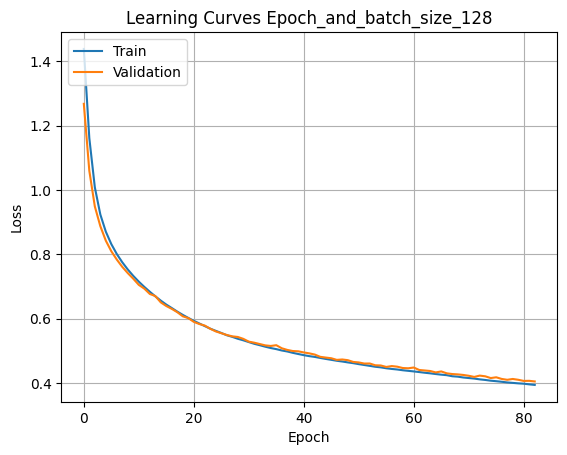

In [12]:
accuracy_measures = {}
model_config = get_base_model_config()

batch_sizes = [32, 64, 128]

for size in batch_sizes:

  model_config['batch_size'] = size

  custom_layers = [
      layers.Dense(32, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];
  model_name = 'Epoch_and_batch_size_' + str(size)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [13]:
accuracy_measures_batch_epoch = accuracy_measures.copy()

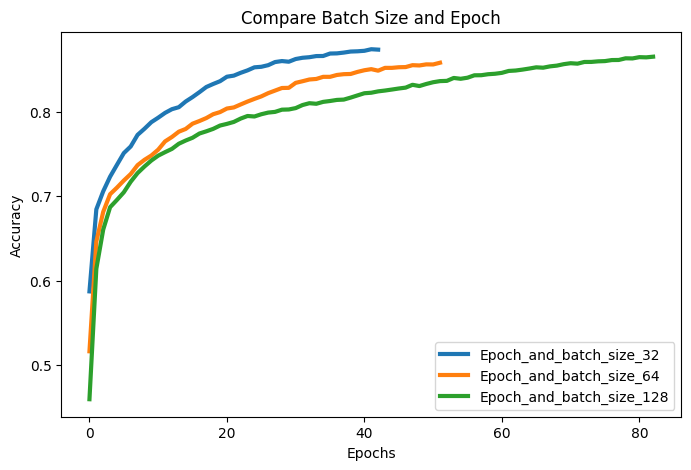

In [14]:
plot_accuracy_measures(accuracy_measures, "Compare Batch Size and Epoch")

For this use case, it seems there is no benefits on increasing the batch size further. Moving forward I am just going to use the batch size of 32.\
Meanwhile, the earliest epoch where stabilization happens was 50.

In [15]:
model_config['batch_size'] = 32
model_config['epochs'] = 50

### Hidden layers tuning

One of the key model architecture hyperparameters is the number of hidden layers. As the number of layers increases, it increases the possibility of learning complex relationships between features and target variables, but it will also increase the cost and time needed for both training and inference. It is also has the risk of overfitting the training set.

A **value of two** has been sufficient for simple problems. It is recommended to increase the number of layers only based on experimentation if the set accuracy levels are not achieved. Otherwise, additional layers will take resources and time without providing any additional value.

Model: "Layers_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            (None, 32)                1664      
                                                                 
 dense_83 (Dense)            (None, 5)                 165       
                                                                 
Total params: 1829 (7.14 KB)
Trainable params: 1829 (7.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 2s 2ms/step - loss: 1.2065 - accuracy: 0.5903 - val_loss: 0.9852 - val_accuracy: 0.6468
Epoch 2/50
636/636 [==============================] - 1s 2ms/step - loss: 0.9123 - accuracy: 0.6781 - val_loss: 0.8487 - val_accuracy: 0.6938
Epoch 3/50
636/636 [==============================] - 2s 3ms/step - loss: 0.8180 - accuracy: 0.7060 - val_loss: 0.7782 - val_accuracy: 0.7

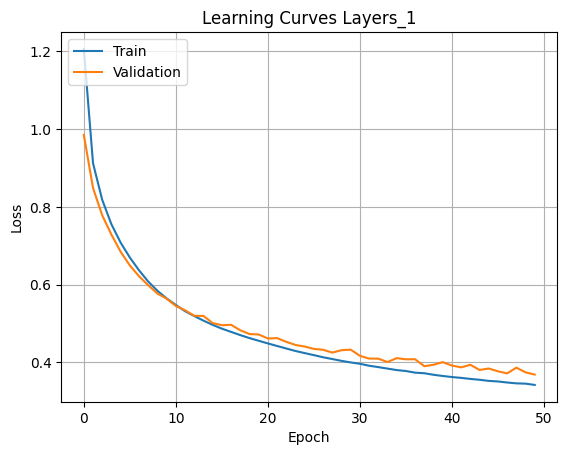

Model: "Layers_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 32)                1664      
                                                                 
 dense_85 (Dense)            (None, 32)                1056      
                                                                 
 dense_86 (Dense)            (None, 5)                 165       
                                                                 
Total params: 2885 (11.27 KB)
Trainable params: 2885 (11.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 2s 3ms/step - loss: 1.1067 - accuracy: 0.6119 - val_loss: 0.8649 - val_accuracy: 0.6895
Epoch 2/50
636/636 [==============================] - 1s 2ms/step - loss: 0.8118 - accuracy: 0.7104 - val_loss: 0.7521 - val_accuracy: 0.7333
Epoc

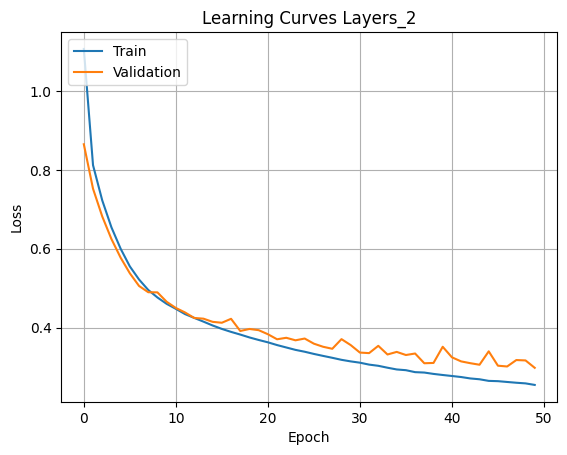

Model: "Layers_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 32)                1664      
                                                                 
 dense_88 (Dense)            (None, 32)                1056      
                                                                 
 dense_89 (Dense)            (None, 32)                1056      
                                                                 
 dense_90 (Dense)            (None, 5)                 165       
                                                                 
Total params: 3941 (15.39 KB)
Trainable params: 3941 (15.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 2s 3ms/step - loss: 1.1400 - accuracy: 0.5826 - val_loss: 0.8935 - val_accuracy: 0.6606
Epoch 2/50
636

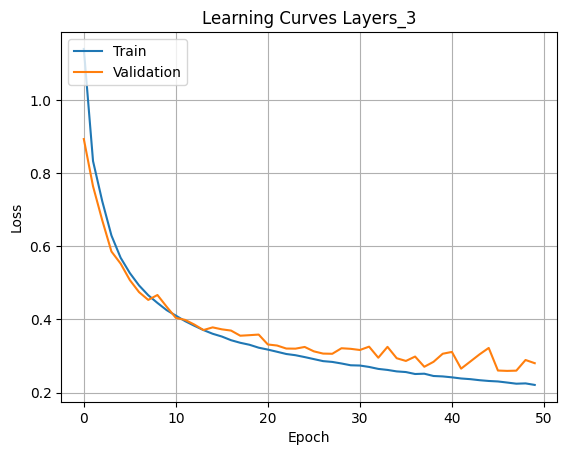

Model: "Layers_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_91 (Dense)            (None, 32)                1664      
                                                                 
 dense_92 (Dense)            (None, 32)                1056      
                                                                 
 dense_93 (Dense)            (None, 32)                1056      
                                                                 
 dense_94 (Dense)            (None, 32)                1056      
                                                                 
 dense_95 (Dense)            (None, 5)                 165       
                                                                 
Total params: 4997 (19.52 KB)
Trainable params: 4997 (19.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [====

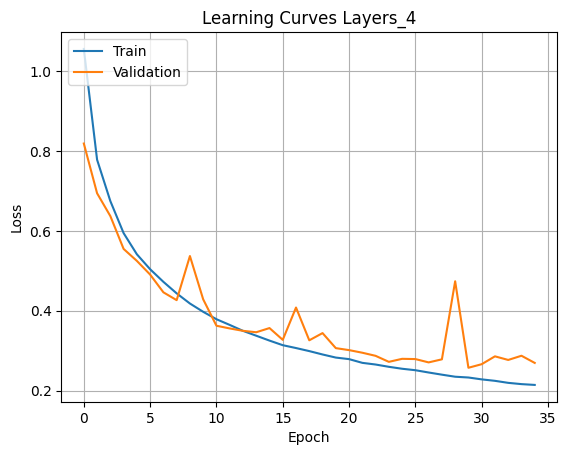

Model: "Layers_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 32)                1664      
                                                                 
 dense_97 (Dense)            (None, 32)                1056      
                                                                 
 dense_98 (Dense)            (None, 32)                1056      
                                                                 
 dense_99 (Dense)            (None, 32)                1056      
                                                                 
 dense_100 (Dense)           (None, 32)                1056      
                                                                 
 dense_101 (Dense)           (None, 5)                 165       
                                                                 
Total params: 6053 (23.64 KB)
Trainable params: 6053 (23.6

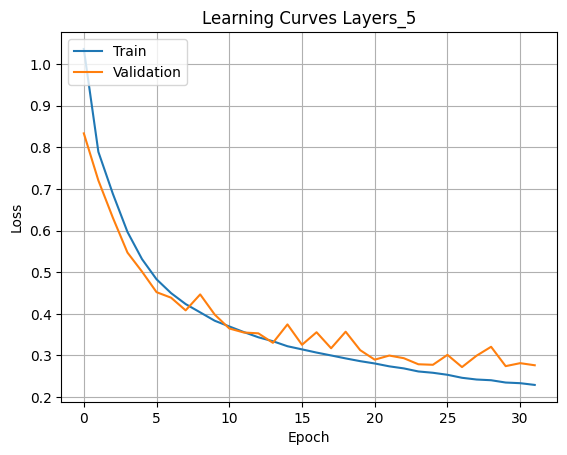

Model: "Layers_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 32)                1664      
                                                                 
 dense_103 (Dense)           (None, 32)                1056      
                                                                 
 dense_104 (Dense)           (None, 32)                1056      
                                                                 
 dense_105 (Dense)           (None, 32)                1056      
                                                                 
 dense_106 (Dense)           (None, 32)                1056      
                                                                 
 dense_107 (Dense)           (None, 32)                1056      
                                                                 
 dense_108 (Dense)           (None, 5)                 165

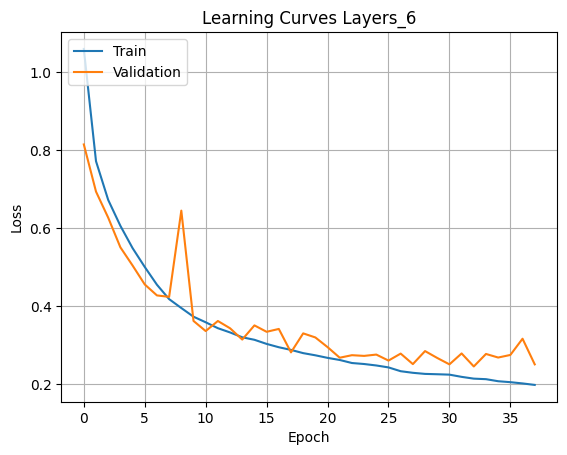

Model: "Layers_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_109 (Dense)           (None, 32)                1664      
                                                                 
 dense_110 (Dense)           (None, 32)                1056      
                                                                 
 dense_111 (Dense)           (None, 32)                1056      
                                                                 
 dense_112 (Dense)           (None, 32)                1056      
                                                                 
 dense_113 (Dense)           (None, 32)                1056      
                                                                 
 dense_114 (Dense)           (None, 32)                1056      
                                                                 
 dense_115 (Dense)           (None, 32)                105

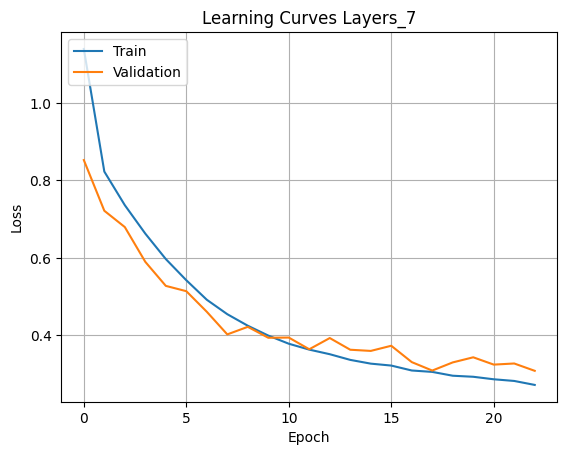

Model: "Layers_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 32)                1664      
                                                                 
 dense_118 (Dense)           (None, 32)                1056      
                                                                 
 dense_119 (Dense)           (None, 32)                1056      
                                                                 
 dense_120 (Dense)           (None, 32)                1056      
                                                                 
 dense_121 (Dense)           (None, 32)                1056      
                                                                 
 dense_122 (Dense)           (None, 32)                1056      
                                                                 
 dense_123 (Dense)           (None, 32)                105

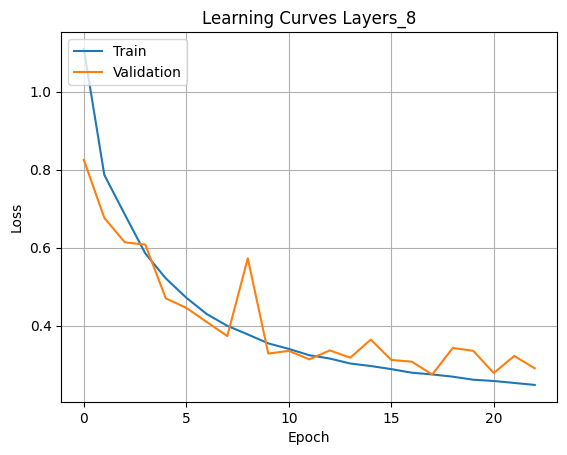

In [22]:
model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50

accuracy_measures = {}

# reused the previous model config from previous experiment.
# but on this case only increase the number of layers

# I will start small by checking if one or two nodes is enough to get a good result.
layer_list = []
for hidden_layer_count in range(1,9):
  custom_layers = []

  # Simply use 32 nodes per layer for now.

  # Input
  if hidden_layer_count == 1:
    custom_layers.append(layers.Dense(32, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']))
  else:
  # Additional Layers
    custom_layers.append(layers.Dense(32, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']))
    for i in range(1, hidden_layer_count):
      custom_layers.append(layers.Dense(32, activation=model_config['hidden_activation']))

  # Output layers
  custom_layers.append(layers.Dense(model_config['output_nodes'], activation=model_config['output_activation']))

  model_name = 'Layers_' + str(hidden_layer_count)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [23]:
accuracy_measures_hidden_layers = accuracy_measures.copy()

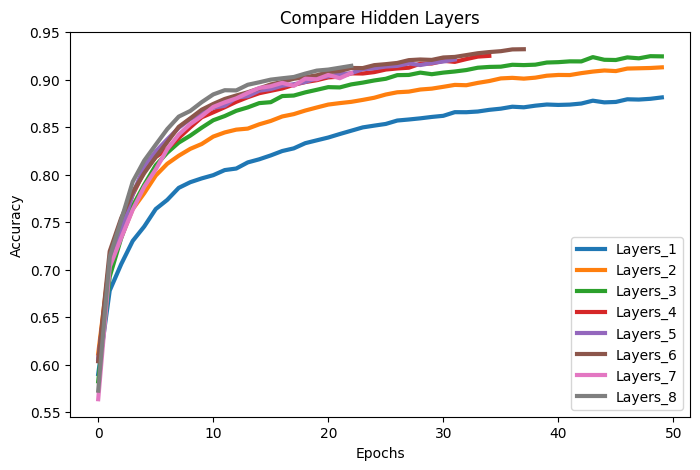

In [24]:
plot_accuracy_measures(accuracy_measures, "Compare Hidden Layers")

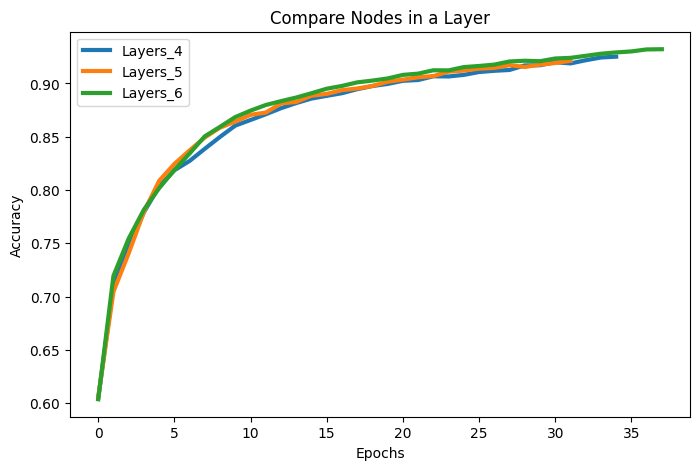

In [25]:
accuracy_measures_tmp = {}
accuracy_measures_tmp['Layers_4'] = accuracy_measures['Layers_4']
accuracy_measures_tmp['Layers_5'] = accuracy_measures['Layers_5']
accuracy_measures_tmp['Layers_6'] = accuracy_measures['Layers_6']

plot_accuracy_measures(accuracy_measures_tmp, "Compare Nodes in a Layer")

The experiment suggest that 5 layers starts with higher accuracy and was able to complete faster. However, I will start small by selecting three layers for now and optimize it. If the result is still not satisfying then I will consider on adding more layers.

### Determining nodes in a layers
More nodes means more possibility for the model to learn complex relationships. However similar to number of layers, it will results to more training and resources.

On my experiment I started with a low number as recommended with 32 nodes.


Model: "Nodes-128-128-128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6656      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 40325 (157.52 KB)
Trainable params: 40325 (157.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 8s 4ms/step - loss: 0.8471 - accuracy: 0.6875 - val_loss: 0.6045 - val_accuracy: 0.7710


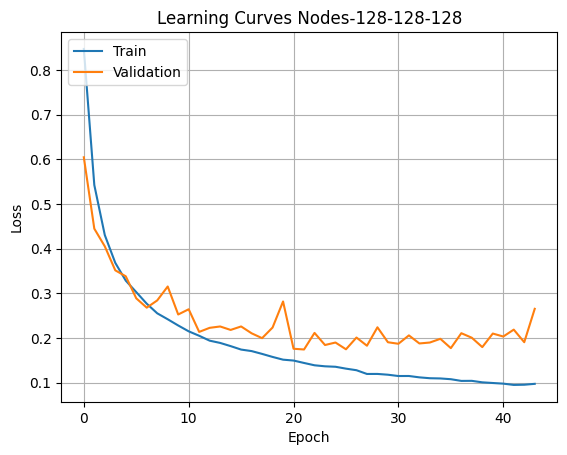

Model: "Nodes-128-128-64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               6656      
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 4s 5ms/step - loss: 0.8828 - accuracy: 0.6761 - val_loss: 0.6537 - val_accuracy: 0.7510
E

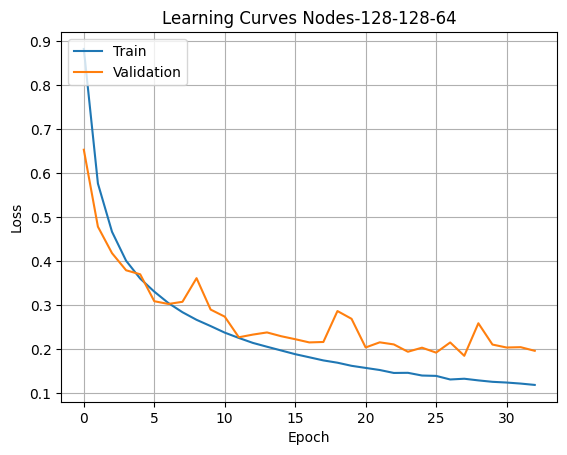

Model: "Nodes-128-128-32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               6656      
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dense_11 (Dense)            (None, 5)                 165       
                                                                 
Total params: 27461 (107.27 KB)
Trainable params: 27461 (107.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 4s 5ms/step - loss: 0.8979 - accuracy: 0.6727 - val_loss: 0.6840 - val_accuracy: 0.7471
E

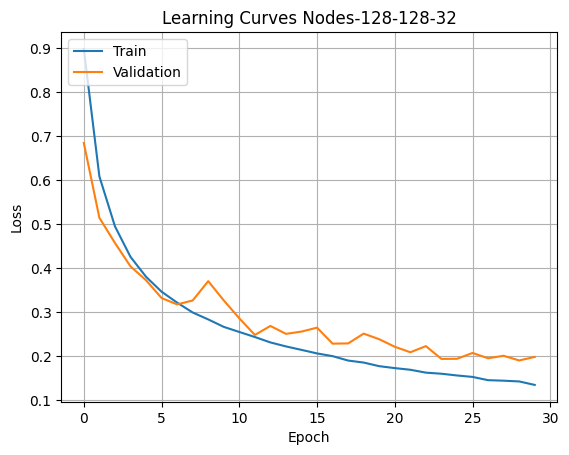

Model: "Nodes-128-64-128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               6656      
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 128)               8320      
                                                                 
 dense_15 (Dense)            (None, 5)                 645       
                                                                 
Total params: 23877 (93.27 KB)
Trainable params: 23877 (93.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 4s 5ms/step - loss: 0.8926 - accuracy: 0.6730 - val_loss: 0.6443 - val_accuracy: 0.7649
Epo

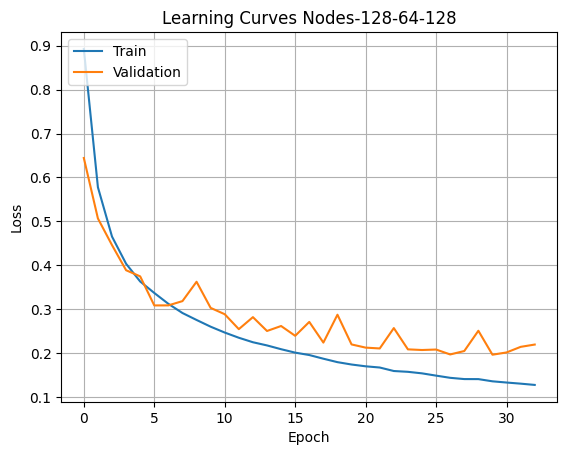

Model: "Nodes-128-64-64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               6656      
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 5)                 325       
                                                                 
Total params: 19397 (75.77 KB)
Trainable params: 19397 (75.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 4s 5ms/step - loss: 0.9111 - accuracy: 0.6680 - val_loss: 0.6821 - val_accuracy: 0.7425
Epoc

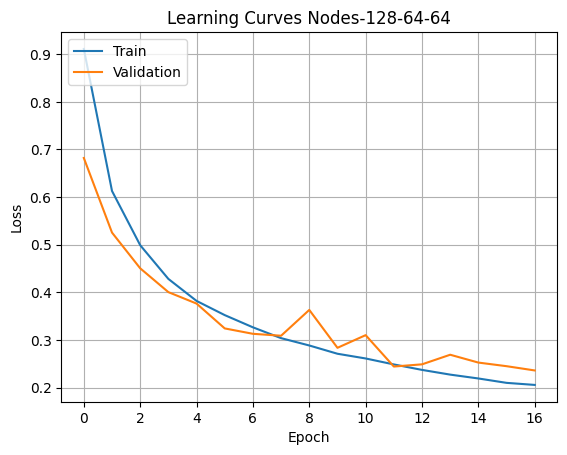

Model: "Nodes-128-64-32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               6656      
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 5)                 165       
                                                                 
Total params: 17157 (67.02 KB)
Trainable params: 17157 (67.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 5s 7ms/step - loss: 0.9779 - accuracy: 0.6457 - val_loss: 0.7501 - val_accuracy: 0.7331
Epoc

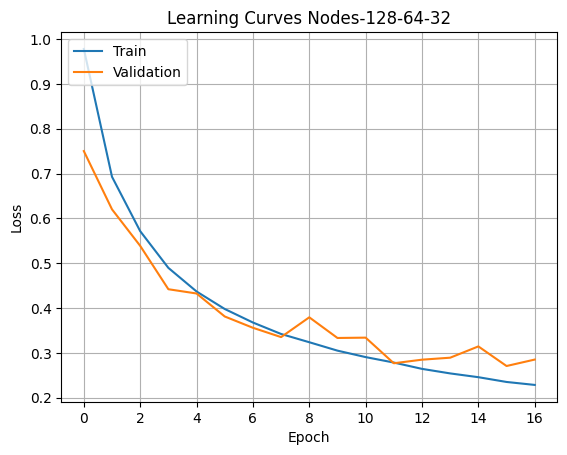

Model: "Nodes-128-32-128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               6656      
                                                                 
 dense_25 (Dense)            (None, 32)                4128      
                                                                 
 dense_26 (Dense)            (None, 128)               4224      
                                                                 
 dense_27 (Dense)            (None, 5)                 645       
                                                                 
Total params: 15653 (61.14 KB)
Trainable params: 15653 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 4s 5ms/step - loss: 0.9347 - accuracy: 0.6602 - val_loss: 0.7054 - val_accuracy: 0.7423
Epo

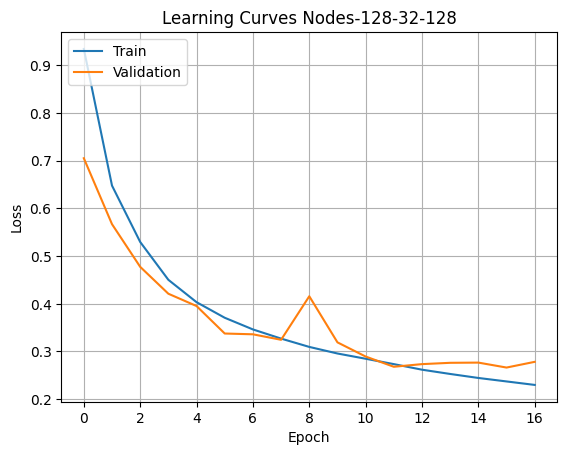

Model: "Nodes-128-32-64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 128)               6656      
                                                                 
 dense_29 (Dense)            (None, 32)                4128      
                                                                 
 dense_30 (Dense)            (None, 64)                2112      
                                                                 
 dense_31 (Dense)            (None, 5)                 325       
                                                                 
Total params: 13221 (51.64 KB)
Trainable params: 13221 (51.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 4s 5ms/step - loss: 0.9452 - accuracy: 0.6581 - val_loss: 0.7100 - val_accuracy: 0.7280
Epoc

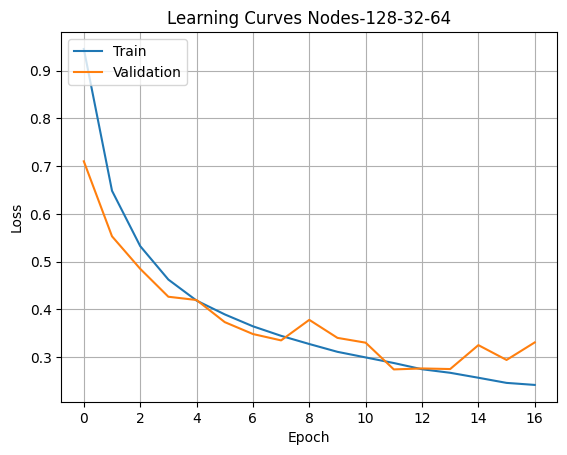

Model: "Nodes-128-32-32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 128)               6656      
                                                                 
 dense_33 (Dense)            (None, 32)                4128      
                                                                 
 dense_34 (Dense)            (None, 32)                1056      
                                                                 
 dense_35 (Dense)            (None, 5)                 165       
                                                                 
Total params: 12005 (46.89 KB)
Trainable params: 12005 (46.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 5s 6ms/step - loss: 0.9716 - accuracy: 0.6497 - val_loss: 0.7471 - val_accuracy: 0.7215
Epoc

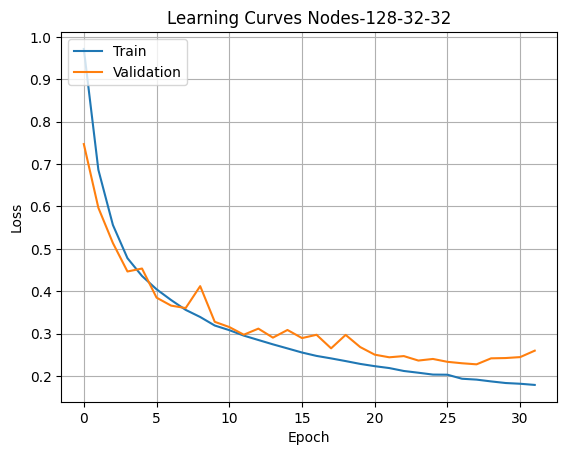

In [ ]:
# reset the accuracy measures
accuracy_measures = {}
model_config = get_base_model_config()

# The list used to have 16, 128 and 256 nodes. I removed those because of resources and performance reasons.
# The result is little improvement on the model accuracy and I also noticed it just caused an overfitting.
# Hence, I am using a nodes combination below on my experiments

#node_list_layer_1 = [32, 64, 128]
#node_list_layer_2 = [32, 64, 128]
#node_list_layer_3 = [32, 64, 128]
node_list_layer_1 = [128]
node_list_layer_2 = [128, 64, 32]
node_list_layer_3 = [128, 64, 32]

for nbr_of_nodes_layer_1 in node_list_layer_1:
  for nbr_of_nodes_layer_2 in node_list_layer_2:
    for nbr_of_nodes_layer_3 in node_list_layer_3:
      custom_layers = [
        layers.Dense(nbr_of_nodes_layer_1, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
        layers.Dense(nbr_of_nodes_layer_2, activation=model_config['hidden_activation']),
        layers.Dense(nbr_of_nodes_layer_3, activation=model_config['hidden_activation']),
        layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
      ];

      model_name = 'Nodes-' + str(nbr_of_nodes_layer_1) + '-' + str(nbr_of_nodes_layer_2) + '-' + str(nbr_of_nodes_layer_3)
      model_config['model_name'] = model_name
      model_config['custom_layers'].clear()
      model_config['custom_layers'].extend(custom_layers)

      history = create_and_run_model(model_config, X_train, y_train_dummy)
      plot_learning_curves(history, model_name)
      accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_measures_nodes = accuracy_measures.copy()

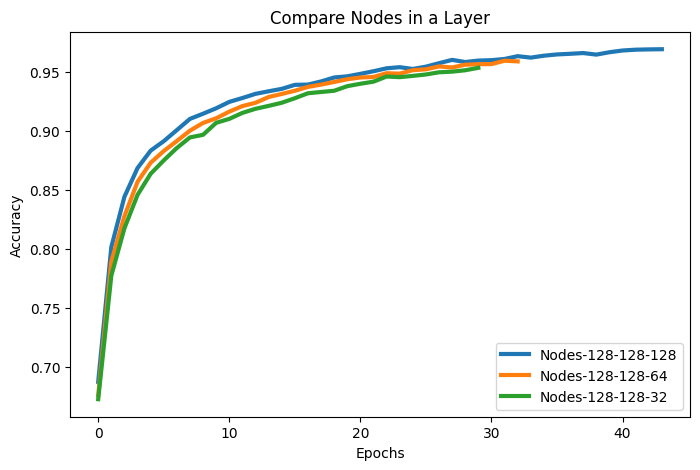

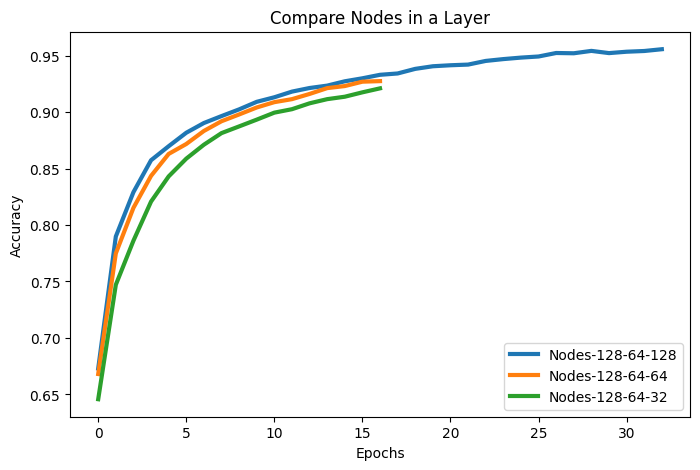

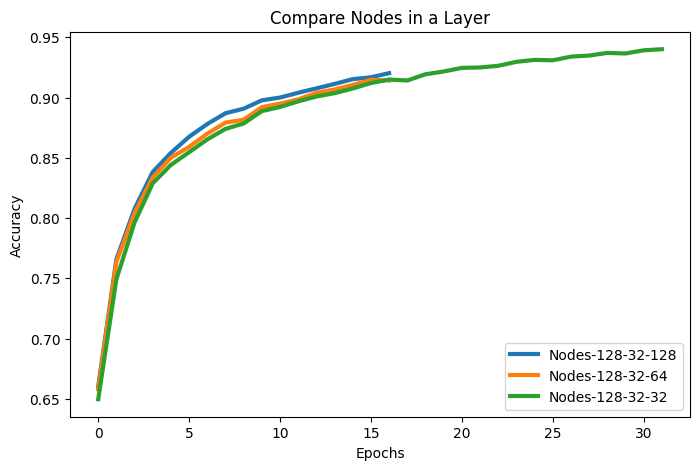

In [ ]:
accuracy_measures_tmp = {}

node_list_layer_1 = [128]
node_list_layer_2 = [128, 64, 32]
node_list_layer_3 = [128, 64, 32]

for nbr_of_nodes_layer_1 in node_list_layer_1:
  for nbr_of_nodes_layer_2 in node_list_layer_2:
    accuracy_measures_tmp = {}
    for nbr_of_nodes_layer_3 in node_list_layer_3:
      model_name = 'Nodes-' + str(nbr_of_nodes_layer_1) + '-' + str(nbr_of_nodes_layer_2) + '-' + str(nbr_of_nodes_layer_3)
      accuracy_measures_tmp[model_name] = accuracy_measures[model_name]
    plot_accuracy_measures(accuracy_measures_tmp, "Compare Nodes in a Layer")

In [ ]:
accuracy_measures_tmp = {}
#accuracy_measures_tmp['Nodes-128-128-64'] = accuracy_measures['Nodes-128-128-64']
#accuracy_measures_tmp['Nodes-128-64-64'] = accuracy_measures['Nodes-128-64-64']
#accuracy_measures_tmp['Nodes-128-32-128'] = accuracy_measures['Nodes-128-32-128']
#accuracy_measures_tmp['Nodes-128-64-32'] = accuracy_measures['Nodes-128-64-32']

#plot_accuracy_measures(accuracy_measures_tmp, "Compare Nodes in a Layer")

The nodes 128 and 64 was faster to complete compared to other combination of nodes and it also offer a good accuracy. The model 128 nodes for both layers have a higher accuracy but it can lead to overfitting. I will use two layers with 128 and 64 nodes assigned respectively.

### Choosing Activation Function

There are number of algorithms available for activation functions. In general, rectified linear unit works best for regular  artificial neural network (ANN) and convolutional network (CNN). Sigmoid works best for RNNs.


Model: "Model-relu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_126 (Dense)           (None, 32)                1664      
                                                                 
 dense_127 (Dense)           (None, 32)                1056      
                                                                 
 dense_128 (Dense)           (None, 32)                1056      
                                                                 
 dense_129 (Dense)           (None, 32)                1056      
                                                                 
 dense_130 (Dense)           (None, 32)                1056      
                                                                 
 dense_131 (Dense)           (None, 32)                1056      
                                                                 
 dense_132 (Dense)           (None, 5)                 1

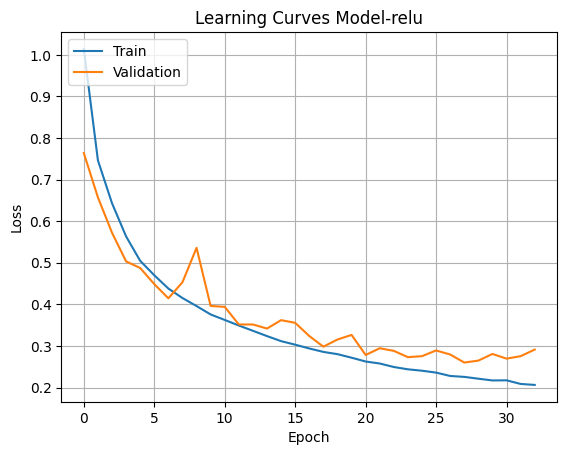

Model: "Model-sigmoid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_133 (Dense)           (None, 32)                1664      
                                                                 
 dense_134 (Dense)           (None, 32)                1056      
                                                                 
 dense_135 (Dense)           (None, 32)                1056      
                                                                 
 dense_136 (Dense)           (None, 32)                1056      
                                                                 
 dense_137 (Dense)           (None, 32)                1056      
                                                                 
 dense_138 (Dense)           (None, 32)                1056      
                                                                 
 dense_139 (Dense)           (None, 5)               

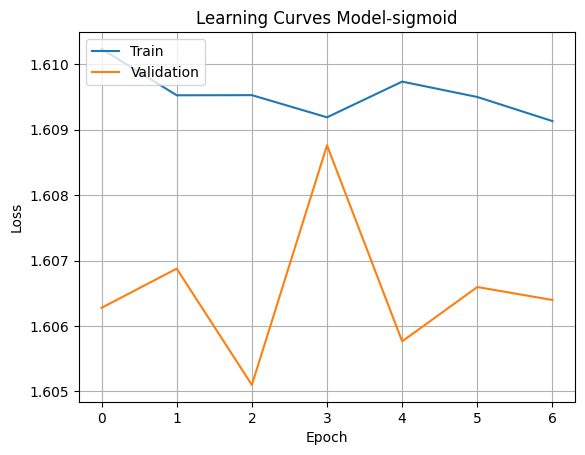

Model: "Model-tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 32)                1664      
                                                                 
 dense_141 (Dense)           (None, 32)                1056      
                                                                 
 dense_142 (Dense)           (None, 32)                1056      
                                                                 
 dense_143 (Dense)           (None, 32)                1056      
                                                                 
 dense_144 (Dense)           (None, 32)                1056      
                                                                 
 dense_145 (Dense)           (None, 32)                1056      
                                                                 
 dense_146 (Dense)           (None, 5)                 1

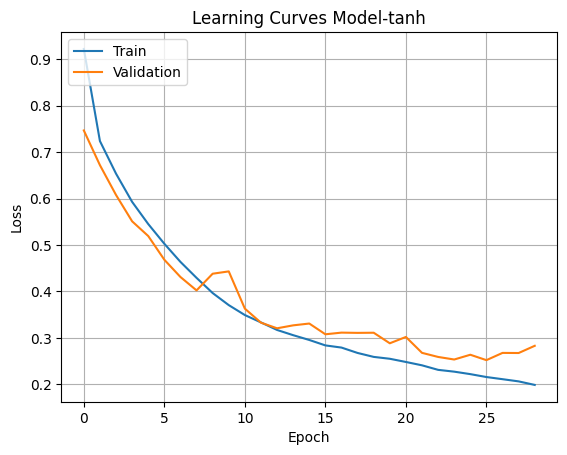

In [26]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 2
# Number of nodes per each layer: 128 64

activation_list = ['relu','sigmoid','tanh']

for activation in activation_list:

  model_config['hidden_activation'] = activation

  custom_layers = [
    layers.Dense(32, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(32, activation=model_config['hidden_activation']),
    layers.Dense(32, activation=model_config['hidden_activation']),
    layers.Dense(32, activation=model_config['hidden_activation']),
    layers.Dense(32, activation=model_config['hidden_activation']),
    layers.Dense(32, activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Model-' + activation
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [27]:
accuracy_activation = accuracy_measures.copy()

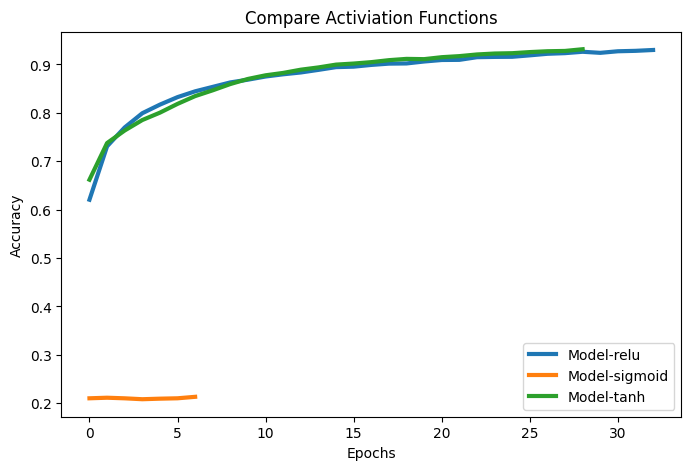

In [28]:
plot_accuracy_measures(accuracy_measures, "Compare Activiation Functions")

The activation function relu have higher accuracy and completed faster.

In [29]:
model_config['hidden_activation'] = 'tanh'

### Initialize Weights
The initial values of weights play a huge role in the speed of learning and finaly accuracy. Multiple initialization techniques exist.

Random normal works best for most cases but we will run an experiment if that is still the case on our dataset.

Model: "Model-random_normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 32)                1664      
                                                                 
 dense_148 (Dense)           (None, 32)                1056      
                                                                 
 dense_149 (Dense)           (None, 32)                1056      
                                                                 
 dense_150 (Dense)           (None, 32)                1056      
                                                                 
 dense_151 (Dense)           (None, 32)                1056      
                                                                 
 dense_152 (Dense)           (None, 32)                1056      
                                                                 
 dense_153 (Dense)           (None, 5)         

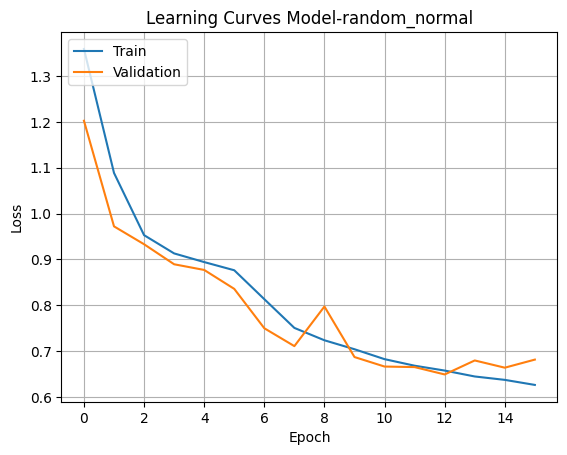

Model: "Model-random_uniform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_154 (Dense)           (None, 32)                1664      
                                                                 
 dense_155 (Dense)           (None, 32)                1056      
                                                                 
 dense_156 (Dense)           (None, 32)                1056      
                                                                 
 dense_157 (Dense)           (None, 32)                1056      
                                                                 
 dense_158 (Dense)           (None, 32)                1056      
                                                                 
 dense_159 (Dense)           (None, 32)                1056      
                                                                 
 dense_160 (Dense)           (None, 5)        

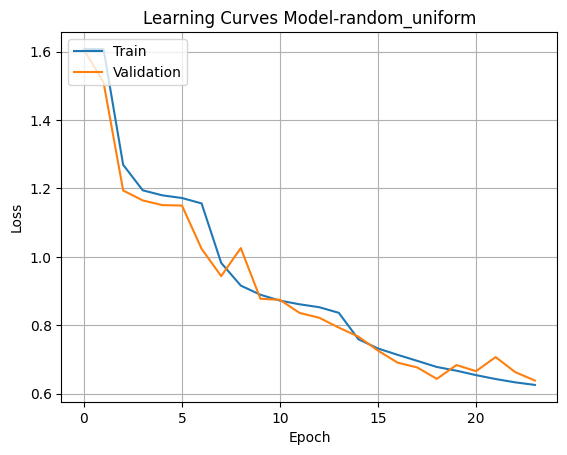

In [30]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 3
# Number of nodes per each layer: 128 64 32
model_config['hidden_activation'] = 'tanh'

#initializer_list = ['random_normal','zeros','ones',"random_uniform"]
initializer_list = ['random_normal',"random_uniform"]

for initializer in initializer_list:

  model_config['weights_initializer'] = initializer

  custom_layers = [
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Model-' + initializer
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [31]:
accuracy_measures_weight_init = accuracy_measures.copy()

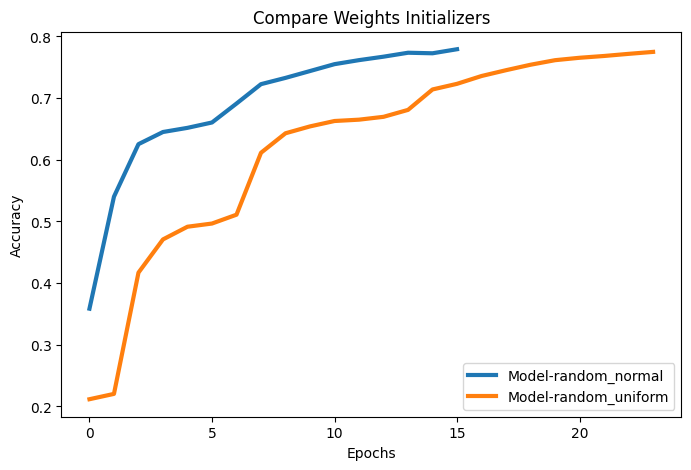

In [32]:
plot_accuracy_measures(accuracy_measures, "Compare Weights Initializers")

Both random_normal and random_uniform have similar high accuracy but random_normal completed faster. Hence, I will simply choose the random_normal as weight initializer.

In [ ]:
model_config['weights_initializer'] = 'random_normal'

## Tuning Back Propagation

### Batch Normalization

Batch normalization is an important technique to vanishing and exploiting gradients during gradient descent. Batch normalization help achieve higher accuracies with lower epochs, hence is also an optimization technique.

*This is no longer necessary because Scaler was already applied during data preparation.*

In [ ]:
'''
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 2
# Number of nodes per each layer: 128 64
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_normal'

normalization_list = ['batch','none']
for normalization in normalization_list:

  custom_layers = []
  if normalization == 'none':
    custom_layers = [
      layers.Dense(128, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dense(64,  kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ];
  else:
    custom_layers = [
      layers.Dense(128, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.BatchNormalization(),
      layers.Dense(64,  kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.BatchNormalization(),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ];


  model_name = 'Normalization-' + normalization
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']
'''

"\naccuracy_measures = {}\n\nmodel_config = get_base_model_config()\n# Hyperparameters:\nmodel_config['batch_size'] = 32\nmodel_config['epochs'] = 50\n# Number of layers: 2\n# Number of nodes per each layer: 128 64\nmodel_config['hidden_activation'] = 'relu'\nmodel_config['weights_initializer'] = 'random_normal'\n\nnormalization_list = ['batch','none']\nfor normalization in normalization_list:\n\n  custom_layers = []\n  if normalization == 'none':\n    custom_layers = [\n      layers.Dense(128, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),\n      layers.Dense(64,  kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),\n      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])\n    ];  \n  else:\n    custom_layers = [\n      layers.Dense(128, kernel_initializer=model_config['weights_initializer'], activation=mo

In [ ]:
#accuracy_measures_normalization = accuracy_measures.copy()

In [ ]:
#plot_accuracy_measures(accuracy_measures, "Compare Normalization Techniques")

The model with Batch normalization starts with higher accuracy and faster to stabilize and complete compared to the other model without normalization.

### Optimizers
Optimizer are key tools, that help gradient descent, achieve faster results. Optimizers are algorithms, that helps speed up the training process.

Model: "Optimizer-sgd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_161 (Dense)           (None, 32)                1664      
                                                                 
 dense_162 (Dense)           (None, 32)                1056      
                                                                 
 dense_163 (Dense)           (None, 32)                1056      
                                                                 
 dense_164 (Dense)           (None, 32)                1056      
                                                                 
 dense_165 (Dense)           (None, 32)                1056      
                                                                 
 dense_166 (Dense)           (None, 32)                1056      
                                                                 
 dense_167 (Dense)           (None, 5)               

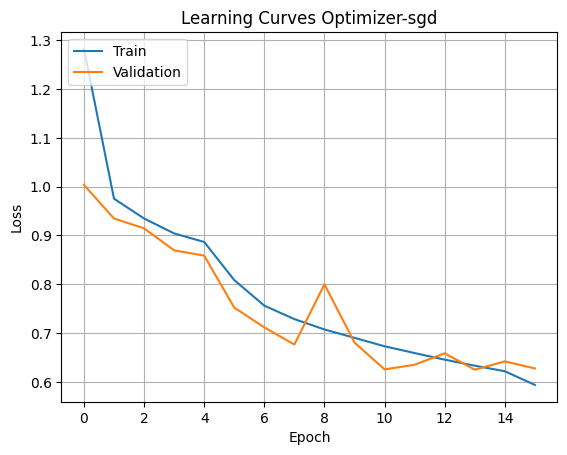

Model: "Optimizer-rmsprop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 32)                1664      
                                                                 
 dense_169 (Dense)           (None, 32)                1056      
                                                                 
 dense_170 (Dense)           (None, 32)                1056      
                                                                 
 dense_171 (Dense)           (None, 32)                1056      
                                                                 
 dense_172 (Dense)           (None, 32)                1056      
                                                                 
 dense_173 (Dense)           (None, 32)                1056      
                                                                 
 dense_174 (Dense)           (None, 5)           

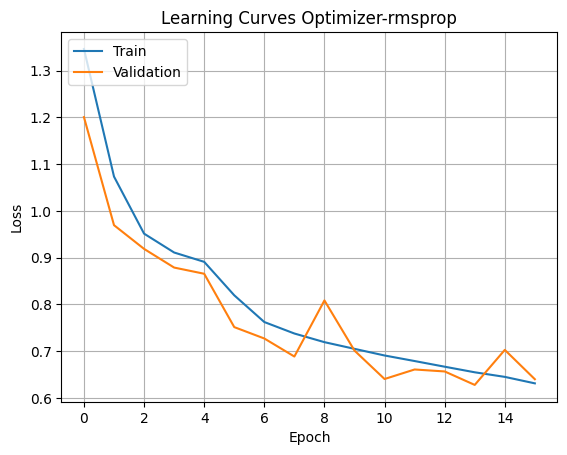

Model: "Optimizer-adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_175 (Dense)           (None, 32)                1664      
                                                                 
 dense_176 (Dense)           (None, 32)                1056      
                                                                 
 dense_177 (Dense)           (None, 32)                1056      
                                                                 
 dense_178 (Dense)           (None, 32)                1056      
                                                                 
 dense_179 (Dense)           (None, 32)                1056      
                                                                 
 dense_180 (Dense)           (None, 32)                1056      
                                                                 
 dense_181 (Dense)           (None, 5)              

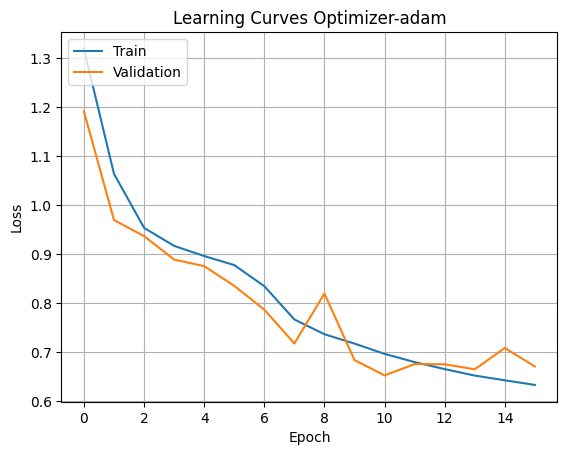

Model: "Optimizer-adagrad"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_182 (Dense)           (None, 32)                1664      
                                                                 
 dense_183 (Dense)           (None, 32)                1056      
                                                                 
 dense_184 (Dense)           (None, 32)                1056      
                                                                 
 dense_185 (Dense)           (None, 32)                1056      
                                                                 
 dense_186 (Dense)           (None, 32)                1056      
                                                                 
 dense_187 (Dense)           (None, 32)                1056      
                                                                 
 dense_188 (Dense)           (None, 5)           

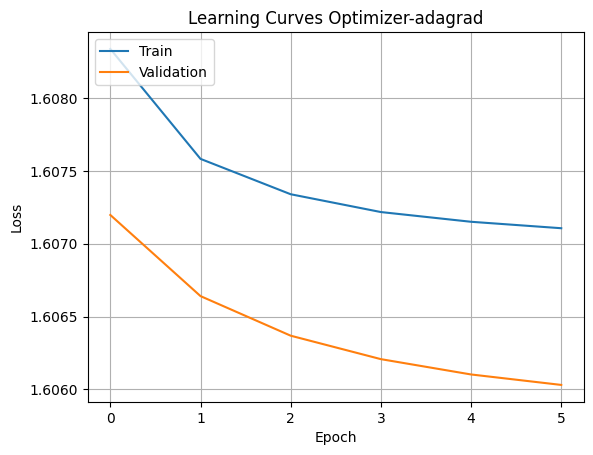

In [33]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 3
# Number of nodes per each layer: 128 64 32
model_config['hidden_activation'] = 'tanh'
model_config['weights_initializer'] = 'random_normal'
# Batch Normalization: not added

optimizer_list = ['sgd','rmsprop','adam','adagrad']

for optimizer in optimizer_list:

  model_config['optimizer'] = optimizer

  custom_layers = [
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Optimizer-' + optimizer
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [34]:
accuracy_measures_optimizer = accuracy_measures.copy()

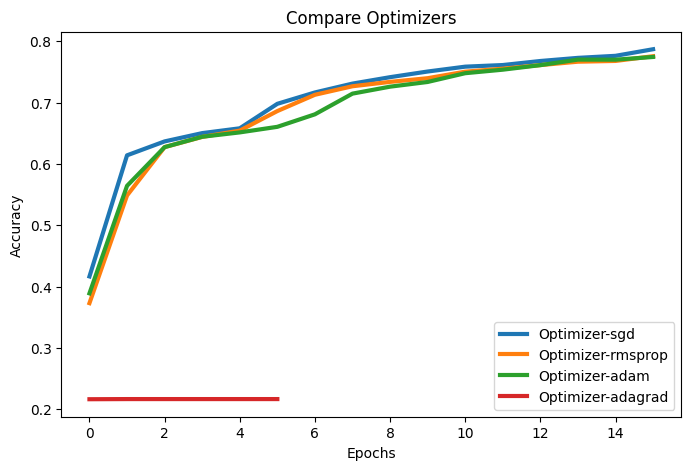

In [35]:
plot_accuracy_measures(accuracy_measures, "Compare Optimizers")

The result is very close, but I will simply use adam for the optimizer.

In [36]:
model_config['optimizer'] = 'sgd'

### Learning Rates

Learning rate is the rate at  which the weights will change in response to the estimated error. It is the speed at which the model is expected to learn from the training data and adjust its weights. Learning rates work in conjunction with the optimizer.

Model: "Learning-Rate-0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_189 (Dense)           (None, 32)                1664      
                                                                 
 dense_190 (Dense)           (None, 32)                1056      
                                                                 
 dense_191 (Dense)           (None, 32)                1056      
                                                                 
 dense_192 (Dense)           (None, 32)                1056      
                                                                 
 dense_193 (Dense)           (None, 32)                1056      
                                                                 
 dense_194 (Dense)           (None, 32)                1056      
                                                                 
 dense_195 (Dense)           (None, 5)         

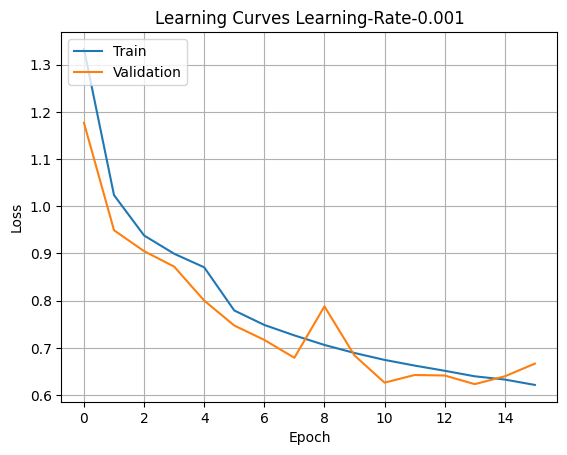

Model: "Learning-Rate-0.005"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_196 (Dense)           (None, 32)                1664      
                                                                 
 dense_197 (Dense)           (None, 32)                1056      
                                                                 
 dense_198 (Dense)           (None, 32)                1056      
                                                                 
 dense_199 (Dense)           (None, 32)                1056      
                                                                 
 dense_200 (Dense)           (None, 32)                1056      
                                                                 
 dense_201 (Dense)           (None, 32)                1056      
                                                                 
 dense_202 (Dense)           (None, 5)         

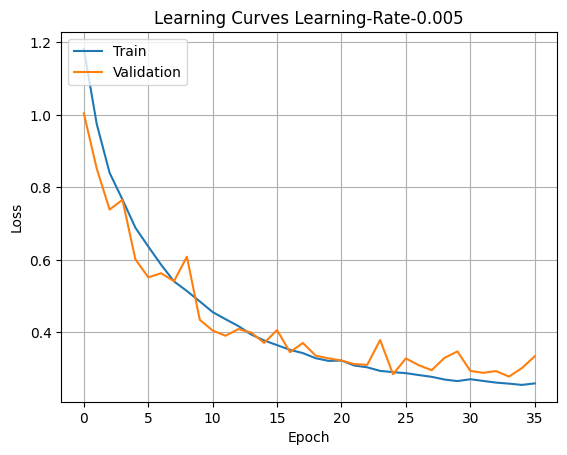

Model: "Learning-Rate-0.01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_203 (Dense)           (None, 32)                1664      
                                                                 
 dense_204 (Dense)           (None, 32)                1056      
                                                                 
 dense_205 (Dense)           (None, 32)                1056      
                                                                 
 dense_206 (Dense)           (None, 32)                1056      
                                                                 
 dense_207 (Dense)           (None, 32)                1056      
                                                                 
 dense_208 (Dense)           (None, 32)                1056      
                                                                 
 dense_209 (Dense)           (None, 5)          

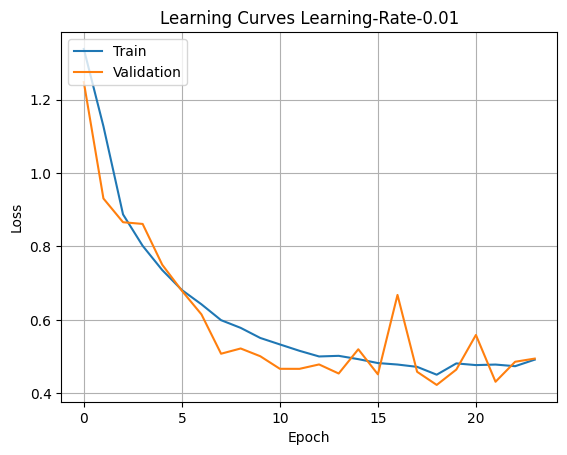

Model: "Learning-Rate-0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_210 (Dense)           (None, 32)                1664      
                                                                 
 dense_211 (Dense)           (None, 32)                1056      
                                                                 
 dense_212 (Dense)           (None, 32)                1056      
                                                                 
 dense_213 (Dense)           (None, 32)                1056      
                                                                 
 dense_214 (Dense)           (None, 32)                1056      
                                                                 
 dense_215 (Dense)           (None, 32)                1056      
                                                                 
 dense_216 (Dense)           (None, 5)           

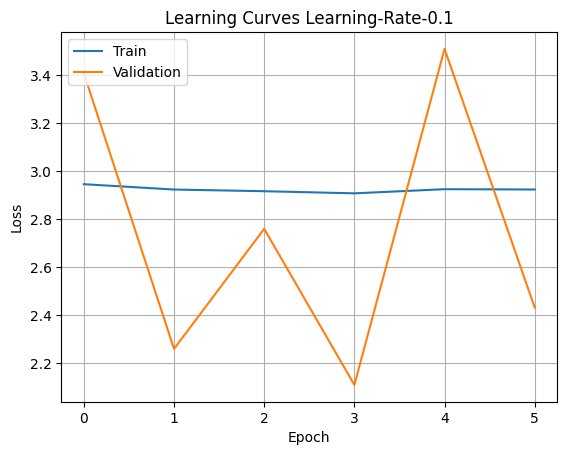

In [37]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 3
# Number of nodes per each layer: 128 64 32
model_config['hidden_activation'] = 'tanh'
model_config['weights_initializer'] = 'random_normal'
# Batch Normalization: added BatchNormalization between the layers
model_config['optimizer'] = 'sgd'

#learning_rate_list = [0.001, 0.005, 0.01, 0.1, 0.5]
learning_rate_list = [0.001, 0.005, 0.01, 0.1]

for learning_rate in learning_rate_list:

  model_config['learning_rate'] = learning_rate

  custom_layers = [
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Learning-Rate-' + str(learning_rate)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [38]:
accuracy_measures_learning_rate = accuracy_measures.copy()

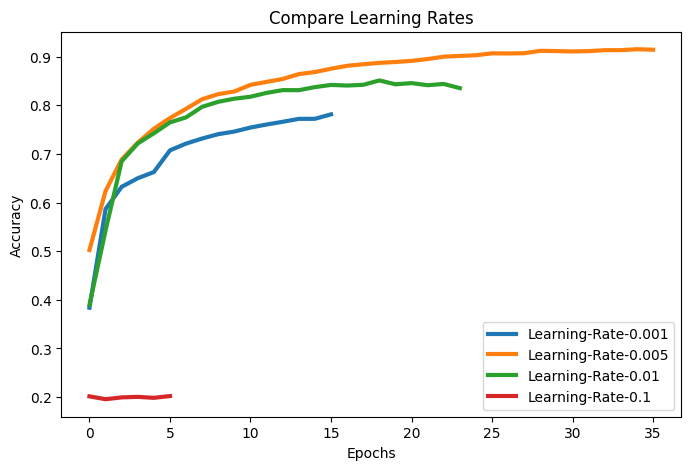

In [39]:
plot_accuracy_measures(accuracy_measures, "Compare Learning Rates")

The learning rate 0.001 is the better choice compared to other learning rates because of higher accuracy.

In [40]:
model_config['learning_rate'] = 0.005

## Overfitting Management

### Regularization
Regularization is an important technique for managing overfitting in neural networks. Regularization algorithms provide an adjustments to the model parameters after they are updated. The adjustment reduces the variance in the model by providing a penalty when overfitting.

Model: "Regularizer-None"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_217 (Dense)           (None, 32)                1664      
                                                                 
 dense_218 (Dense)           (None, 32)                1056      
                                                                 
 dense_219 (Dense)           (None, 32)                1056      
                                                                 
 dense_220 (Dense)           (None, 32)                1056      
                                                                 
 dense_221 (Dense)           (None, 32)                1056      
                                                                 
 dense_222 (Dense)           (None, 32)                1056      
                                                                 
 dense_223 (Dense)           (None, 5)            

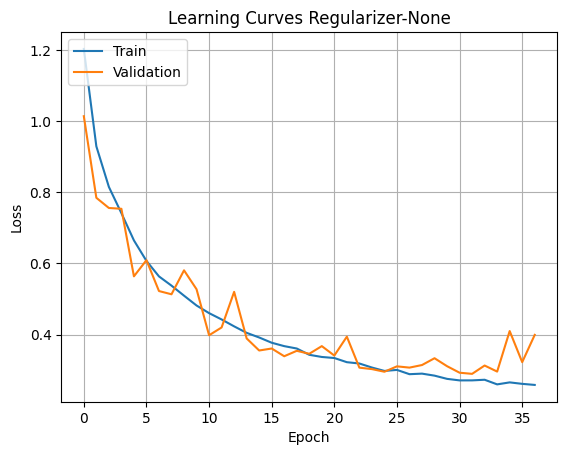

Model: "Regularizer-l1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_224 (Dense)           (None, 32)                1664      
                                                                 
 dense_225 (Dense)           (None, 32)                1056      
                                                                 
 dense_226 (Dense)           (None, 32)                1056      
                                                                 
 dense_227 (Dense)           (None, 32)                1056      
                                                                 
 dense_228 (Dense)           (None, 32)                1056      
                                                                 
 dense_229 (Dense)           (None, 32)                1056      
                                                                 
 dense_230 (Dense)           (None, 5)              

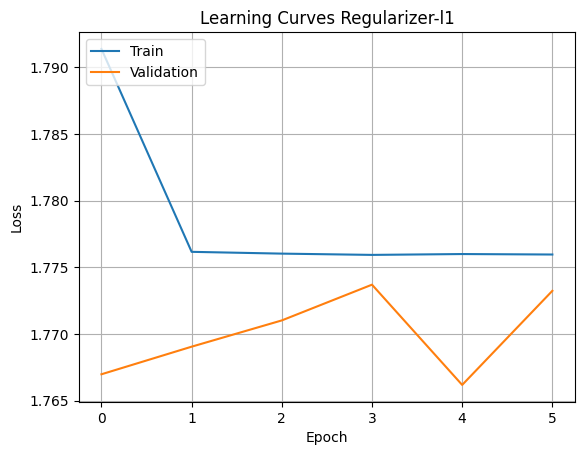

Model: "Regularizer-l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_231 (Dense)           (None, 32)                1664      
                                                                 
 dense_232 (Dense)           (None, 32)                1056      
                                                                 
 dense_233 (Dense)           (None, 32)                1056      
                                                                 
 dense_234 (Dense)           (None, 32)                1056      
                                                                 
 dense_235 (Dense)           (None, 32)                1056      
                                                                 
 dense_236 (Dense)           (None, 32)                1056      
                                                                 
 dense_237 (Dense)           (None, 5)              

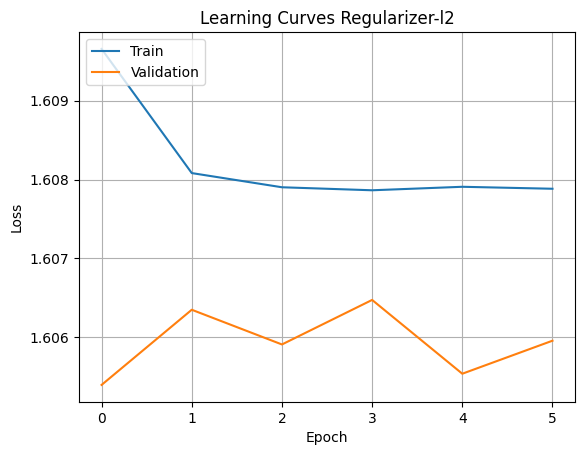

Model: "Regularizer-l1_l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_238 (Dense)           (None, 32)                1664      
                                                                 
 dense_239 (Dense)           (None, 32)                1056      
                                                                 
 dense_240 (Dense)           (None, 32)                1056      
                                                                 
 dense_241 (Dense)           (None, 32)                1056      
                                                                 
 dense_242 (Dense)           (None, 32)                1056      
                                                                 
 dense_243 (Dense)           (None, 32)                1056      
                                                                 
 dense_244 (Dense)           (None, 5)           

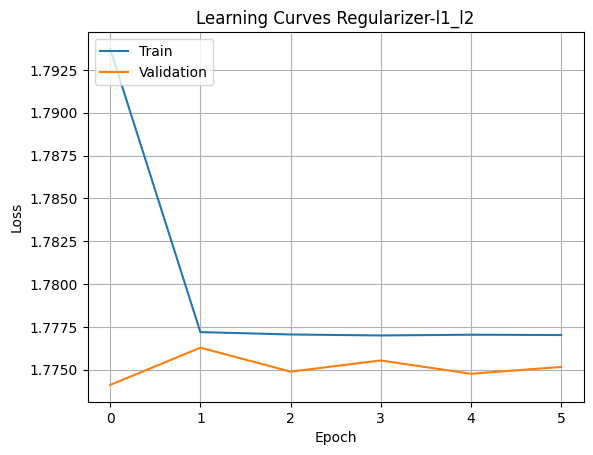

In [41]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 3
# Number of nodes per each layer: 128 64 32
model_config['hidden_activation'] = 'tanh'
model_config['weights_initializer'] = 'random_normal'
# Batch Normalization: added BatchNormalization between the layers
model_config['optimizer'] = 'sgd'
model_config['learning_rate'] = 0.005

regularizer_list = ['None', 'l1','l2','l1_l2']

for regularizer in regularizer_list:
  if regularizer == 'None':
    regularizer = None

  model_config['regularizer'] = regularizer

  custom_layers = [
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Regularizer-' + str(regularizer)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)

  # Used the validation accuracy
  accuracy_measures[model_name] = history.history['val_accuracy']

In [ ]:
accuracy_measures_regularizer = accuracy_measures.copy()

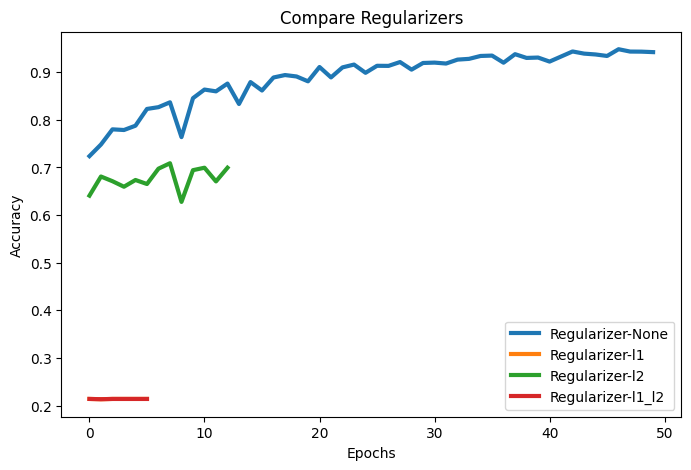

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Regularizers")

The l2 regularizer produce better accuracy and stability.

In [ ]:
model_config['regularizer'] = None

### Dropout
Dropout works during forward propagation. By default, during forward propagation, the  output of each node in the layer is sent every node in the next layer. When using dropout, the outputs of some of the nodes in the layer are dropped randomly.

Model: "Dropout-0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_245 (Dense)           (None, 32)                1664      
                                                                 
 dense_246 (Dense)           (None, 32)                1056      
                                                                 
 dense_247 (Dense)           (None, 32)                1056      
                                                                 
 dense_248 (Dense)           (None, 32)                1056      
                                                                 
 dense_249 (Dense)           (None, 32)                1056      
                                                                 
 dense_250 (Dense)           (None, 32)                1056      
                                                                 
 dense_251 (Dense)           (None, 5)                 

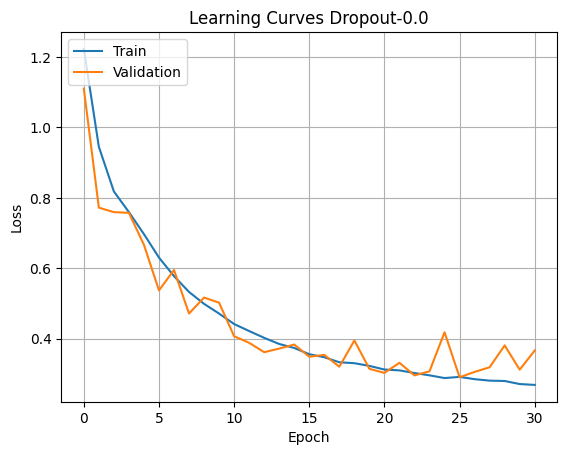

Model: "Dropout-0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_252 (Dense)           (None, 32)                1664      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_253 (Dense)           (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_254 (Dense)           (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_255 (Dense)           (None, 32)              

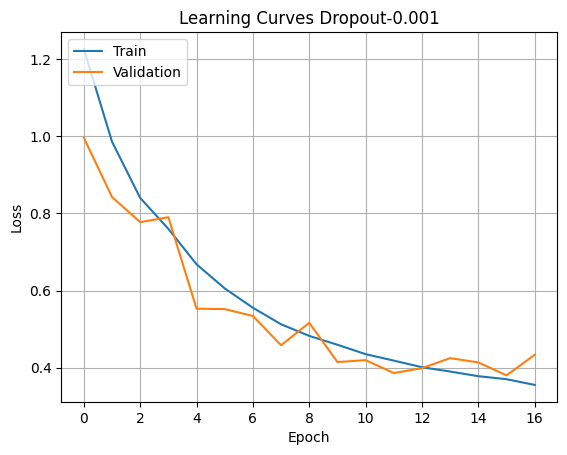

Model: "Dropout-0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_259 (Dense)           (None, 32)                1664      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_260 (Dense)           (None, 32)                1056      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_261 (Dense)           (None, 32)                1056      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_262 (Dense)           (None, 32)                

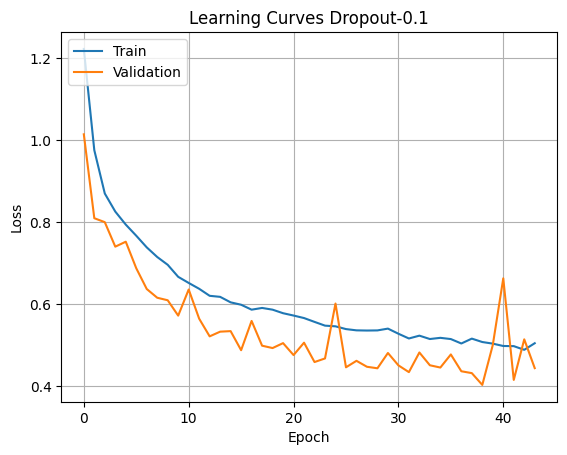

Model: "Dropout-0.2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_266 (Dense)           (None, 32)                1664      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_267 (Dense)           (None, 32)                1056      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_268 (Dense)           (None, 32)                1056      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_269 (Dense)           (None, 32)                

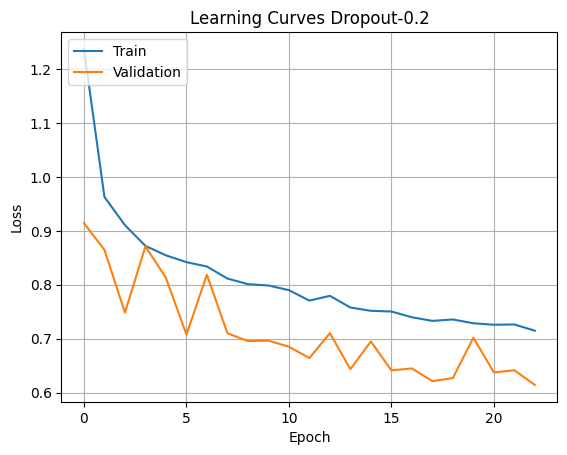

Model: "Dropout-0.5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_273 (Dense)           (None, 32)                1664      
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_274 (Dense)           (None, 32)                1056      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_275 (Dense)           (None, 32)                1056      
                                                                 
 dropout_20 (Dropout)        (None, 32)                0         
                                                                 
 dense_276 (Dense)           (None, 32)                

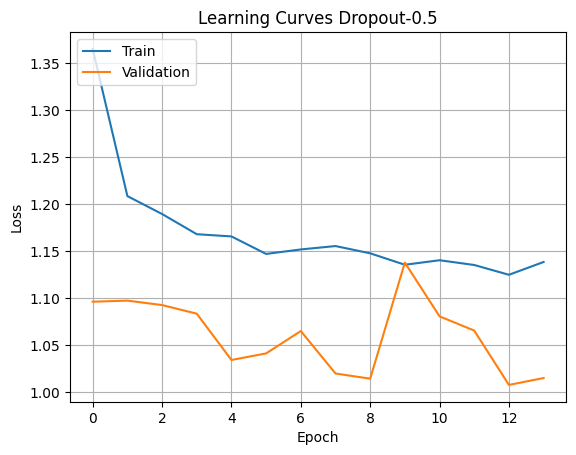

In [42]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 3
# Number of nodes per each layer: 128 64 32
model_config['hidden_activation'] = 'tanh'
model_config['weights_initializer'] = 'random_normal'
# Batch Normalization: added BatchNormalization between the layers
model_config['optimizer'] = 'sgd'
model_config['learning_rate'] = 0.005
model_config['regularizer'] = None
model_config['dropout_rate'] = 0.0

dropout_list = [0.0, 0.001, 0.1, 0.2, 0.5]

for dropout in dropout_list:

  model_config['dropout_rate'] = dropout

  custom_layers = []

  if model_config['dropout_rate'] > 0.0:
    custom_layers = [
      layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(32,  kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(32,  kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(32,  kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(32,  kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(32,  kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ];
  else:
    custom_layers = [
      layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ];

  model_name = 'Dropout-' + str(dropout)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)

  # Used the validation accuracy
  accuracy_measures[model_name] = history.history['val_accuracy']

In [43]:
accuracy_measures_dropout = accuracy_measures.copy()

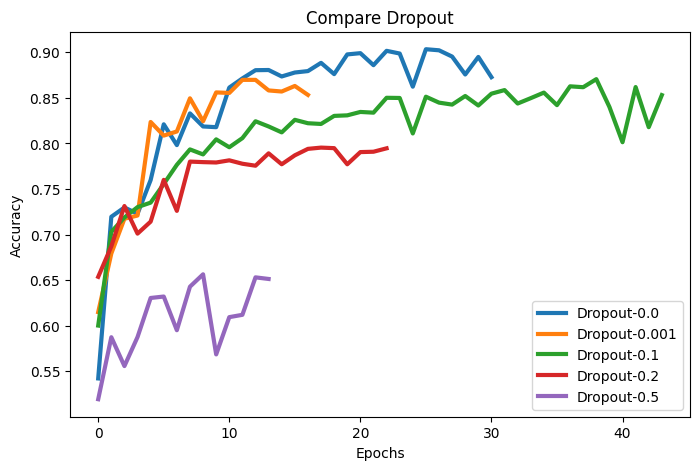

In [44]:
plot_accuracy_measures(accuracy_measures, "Compare Dropout")

I will be using the dropoout rate of 0.1 since it starts on higher accuracy and it show's it is more stable compared to other drop out rates. Another possible candidate is 0.2 but it seems flakey compared to 0.1.

In [ ]:
model_config['dropout_rate'] = 0.0

# Model - Evaluation

In [45]:
def get_best_param_model_config(model_name):
  """
  (str) -> dict

  This method returns the best hyper parameters from experiments.

  Parameters
  ----------
  model_name - The name of the model

  Returns
  ----------
  dict - The dictionary containing the best hyper parameters from experiments.
  """
  # Default model config
  model_config = get_base_model_config()

  model_config['model_name'] = model_name

  # These are the final hyperparameters that I will use in training the Models:
  # Hyperparameters:
  # TODO:
  # Hyperparameters:
  model_config['batch_size'] = 32
  model_config['epochs'] = 50
  # Number of layers: 3
  # Number of nodes per each layer: 128 64 32
  model_config['hidden_activation'] = 'tanh'
  model_config['weights_initializer'] = 'random_normal'
  # Batch Normalization: added BatchNormalization between the layers
  model_config['optimizer'] = 'sgd'
  model_config['learning_rate'] = 0.005
  model_config['regularizer'] = None
  #model_config['dropout_rate'] = 0.0

  custom_layers = [
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  # we would like to save the model starting here for evaluation.
  model_config['is_save_model'] = True

  return model_config

In [46]:
from keras.models import load_model

def evaluate_model(model_config, X, y):
  """
  (dict, tf.data.Dataset)

  This is a reusable function that load a previously trained model and run an evaluation.

  Parameters
  ----------
  model_config - The dictionary to use in model evaluation.
  test_ds - The test dataset to use in the evaluation.

  Returns
  ----------
  Dataframe - The Panda Dataframe containing the scores from the experiment. The scores includes the Accuracy and Loss.
  """
  model_file = str(model_config['workspace_path']) + str(model_config['model_name']) + '.h5'
  model = load_model(model_file)


  #result = model.evaluate(test_ds)

  #result_in_dict = dict(zip(model.metrics_names, result))

  #loss = result_in_dit['loss']
  #accuracy = result_in_dict['accuracy']

  #scores_df = pd.DataFrame([[accuracy, loss]], ['Score'], ['Accuracy', 'Loss'])

  #return scores_df
  test_loss, test_acc = model.evaluate(X, y, verbose=2)
  print(f"Test accuracy: {test_acc}")

In [47]:
# reset accuracy measures
accuracy_measures = {}

In [48]:
model_name = 'model_c1_5layers'
model_config = get_best_param_model_config(model_name)

model_1_history = create_and_run_model(model_config, X_train, y_train_dummy)

Model: "model_c1_5layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_280 (Dense)           (None, 32)                1664      
                                                                 
 dense_281 (Dense)           (None, 32)                1056      
                                                                 
 dense_282 (Dense)           (None, 32)                1056      
                                                                 
 dense_283 (Dense)           (None, 32)                1056      
                                                                 
 dense_284 (Dense)           (None, 32)                1056      
                                                                 
 dense_285 (Dense)           (None, 32)                1056      
                                                                 
 dense_286 (Dense)           (None, 5)            

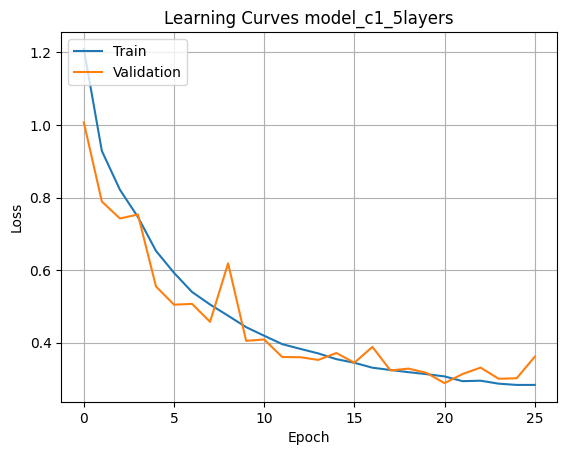

In [49]:
plot_learning_curves(model_1_history, model_name)

In [50]:
evaluate_model(model_config, X_test, y_test_dummy)

341/341 - 1s - loss: 0.2860 - accuracy: 0.9058 - 937ms/epoch - 3ms/step
Test accuracy: 0.9057971239089966
